In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [3]:
df=pd.read_csv('transfusion.data')

In [4]:
df.head(4)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1


In [5]:
df.shape

(748, 5)

In [6]:
df.isnull().sum()

Recency (months)                              0
Frequency (times)                             0
Monetary (c.c. blood)                         0
Time (months)                                 0
whether he/she donated blood in March 2007    0
dtype: int64

In [7]:
df.rename(columns={'whether he/she donated blood in March 2007':'Target'},inplace=True)

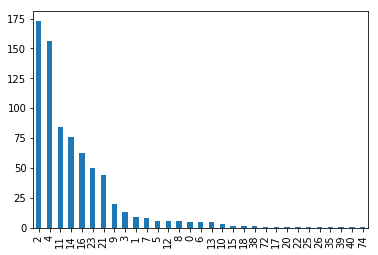

In [8]:
df['Recency (months)'].value_counts().plot(kind='bar')

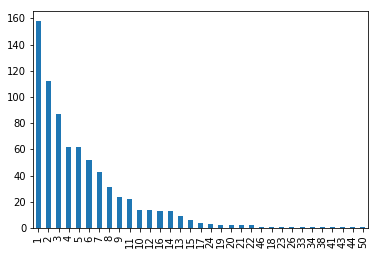

In [9]:
df['Frequency (times)'].value_counts().plot(kind='bar')

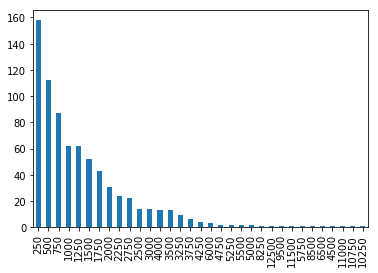

In [10]:
    df['Monetary (c.c. blood)'].value_counts().plot(kind='bar')

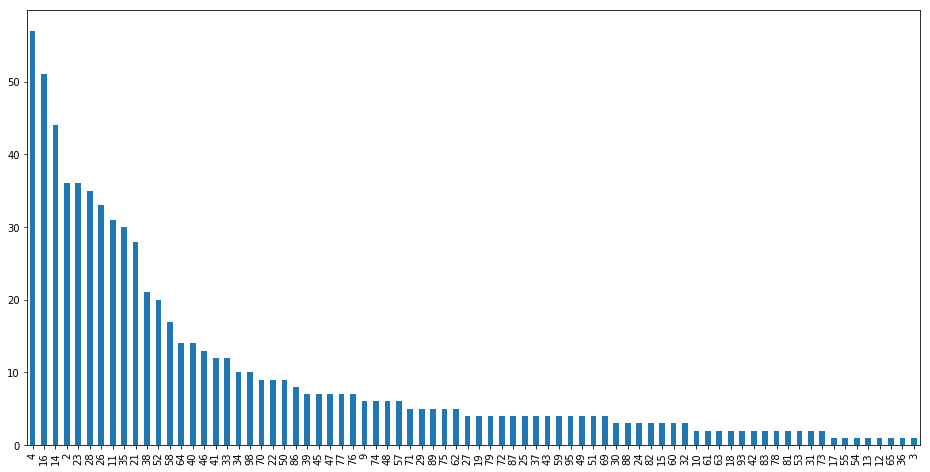

In [11]:
plt.figure(figsize=(16,8))
df['Time (months)'].value_counts().plot(kind='bar')

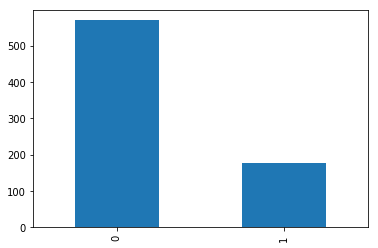

In [12]:
df['Target'].value_counts().plot(kind='bar')

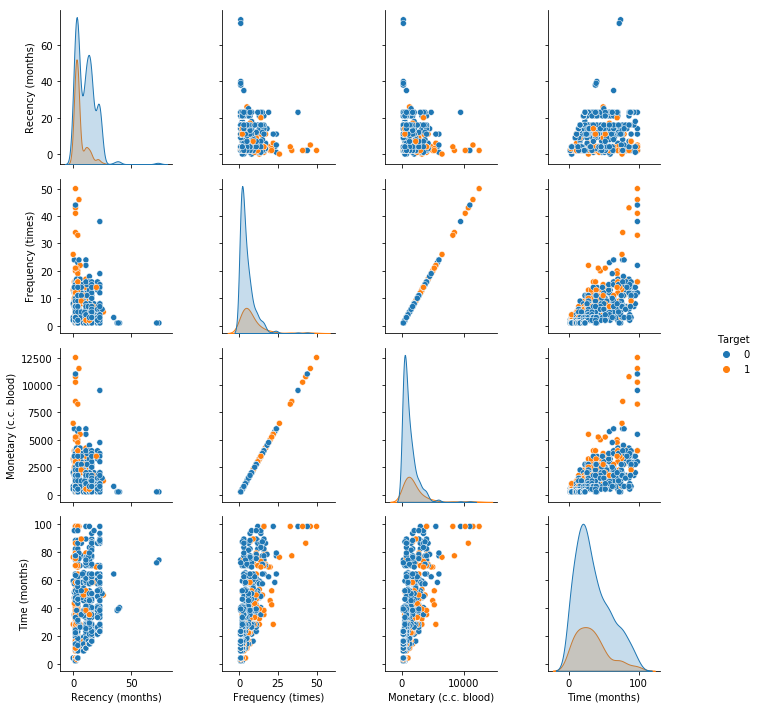

In [13]:
sns.pairplot(df,hue='Target')

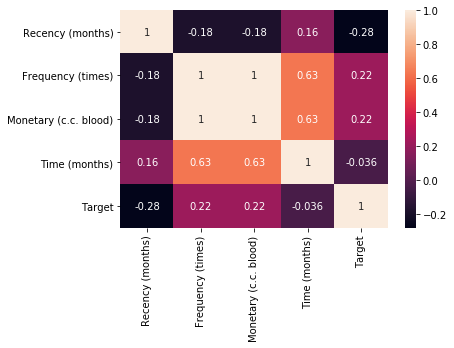

In [14]:
sns.heatmap(df.corr(),annot=True)

In [15]:
df.head(5)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),Target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [16]:
y=df['Target']
X=df.drop(['Target'],axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

TPOT Machine Learning Pipeline

TPOT will automatically explore hundreds of possible pipelines to find the best one for our dataset. Note, the outcome of this search will be a scikit-learn pipeline, meaning it will include any pre-processing steps as well as the model.

We are using TPOT to help us zero in on one model that we can then explore and optimize further.

In [17]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)


C:\Users\Debapriyo\AppData\Roaming\Python\Python36\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.7422459184429089
Generation 2 - Current best internal CV score: 0.7422459184429089
Generation 3 - Current best internal CV score: 0.7422459184429089
Generation 4 - Current best internal CV score: 0.7422459184429089
Generation 5 - Current best internal CV score: 0.7423330644124079
Best pipeline: LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=5,
               log_file=<ipykernel.iostream.OutStream object at 0x0000021AAFBB5828>,
               population_size=20, random_state=42, scoring='roc_auc',
               verbosity=2)

In [18]:
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


AUC score: 0.7853

Best pipeline steps:
1. LogisticRegression(C=0.1, random_state=42)


___________________________________________________________________________
___________________________________________________________________________
TPOT picked LogisticRegression as the best model for our dataset with no pre-processing steps, giving us the AUC score of 0.7853. This is a great starting point. Let's see if we can make it better.

One of the assumptions for linear regression models is that the data and the features we are giving it are related in a linear fashion, or can be measured with a linear distance metric. If a feature in our dataset has a high variance that's an order of magnitude or more greater than the other features, this could impact the model's ability to learn from other features in the dataset.

Correcting for high variance is called normalization. It is one of the possible transformations you do before training a model. Let's check the variance to see if such transformation is needed.

In [19]:
X_train.var().round(3)

Recency (months)              66.929
Frequency (times)             33.830
Monetary (c.c. blood)    2114363.700
Time (months)                611.147
dtype: float64

___________________________________________________________________________
___________________________________________________________________________
Monetary (c.c. blood)'s variance is very high in comparison to any other column in the dataset. This means that, unless accounted for, this feature may get more weight by the model (i.e., be seen as more important) than any other feature.

One way to correct for high variance is to use log normalization.

In [20]:
X_train['Monetary (c.c. blood)']=np.log(df['Monetary (c.c. blood)'])

C:\Users\Debapriyo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
X_test['Monetary (c.c. blood)']=np.log(df['Monetary (c.c. blood)'])

C:\Users\Debapriyo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
X_train.var().round(3)

Recency (months)          66.929
Frequency (times)         33.830
Monetary (c.c. blood)      0.837
Time (months)            611.147
dtype: float64

In [23]:
from sklearn.linear_model import LogisticRegression

logreg =LogisticRegression(solver='liblinear',random_state=42)

logreg.fit(X_train, y_train)

logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7891


The demand for blood fluctuates throughout the year. As one prominent example, blood donations slow down during busy holiday seasons. An accurate forecast for the future supply of blood allows for an appropriate action to be taken ahead of time and therefore saving more lives.

In this notebook, we explored automatic model selection using TPOT and AUC score we got was 0.7891. This is better than simply choosing 0 all the time (the target incidence suggests that such a model would have 76% success rate). We then log normalized our training data and improved the AUC score by 0.5%. In the field of machine learning, even small improvements in accuracy can be important, depending on the purpose.

Another benefit of using logistic regression model is that it is interpretable. We can analyze how much of the variance in the response variable (target) can be explained by other variables in our dataset.

In [24]:
import pickle

pickle.dump(logreg,open('logreg.pkl','wb'))

In [25]:
df.columns

Index(['Recency (months)', 'Frequency (times)', 'Monetary (c.c. blood)',
       'Time (months)', 'Target'],
      dtype='object')